# Fetch Rewards Coding Exercise
In this script, I re-structured the receipts.json, brands.json, and users.json into a structured, tabular format.

## STEP 1 - Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime

## Reading the Json files

In [8]:
receipts = pd.read_json('/Users/spartan/Downloads/receipts.json', lines=True)
users = pd.read_json('/Users/spartan/Downloads/users.json', lines=True)
brands = pd.read_json('/Users/spartan/Downloads/brands.json', lines=True)

## STEP 2 - Transforming the Receipts Table: 
1. Extracting the necessary columns for the Receipts table.
2. Create an Items table from the nested list of items within each receipt.

In [13]:
# Extract the oid values for receipt_id
receipts['receipt_id'] = receipts['_id'].apply(lambda x: x['$oid'])

# Create a function to cast specific columns to datetime
def cast_to_datetime(df, col):
    ans = []
    for x in df[col].values:
        if type(x) == float:
            ans.append(np.nan)
        else:
            # Assuming the datetime is in milliseconds
            ans.append(pd.to_datetime(datetime.fromtimestamp(x['$date'] // 1000)))
    df[col] = ans
    return df

# Columns that need to be transformed to datetime
date_cols = ['createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'purchaseDate']

# Apply the datetime transformation
for col in date_cols:
    receipts = cast_to_datetime(receipts, col)

# Drop the original '_id' column since we've extracted 'receipt_id'
receipts.drop('_id', axis=1, inplace=True)


## STEP 3 - Creating the Items table

In [16]:
# Generate the Items table by examining the rewardsReceiptItemList in receipts data
items = pd.DataFrame()
items['receipt_id'] = ''

# Loop over the receipts to create the Items table from rewardsReceiptItemList
for i in range(len(receipts['rewardsReceiptItemList'])):
    item_list = receipts['rewardsReceiptItemList'].iloc[i]
    if type(item_list) != float:
        for item in item_list:
            temp_df = pd.DataFrame.from_dict(item, orient='index').transpose()
            temp_df['receipt_id'] = receipts.iloc[i]['receipt_id']
            items = pd.concat([items, temp_df], ignore_index=True)

In [25]:
# Save the tables as CSV 
receipts.to_csv('receipts.csv', index=False)
items.to_csv('items.csv', index=False)

In [29]:
# View the first 5 rows of receipts and items dataframes
print(receipts.head()) 

   bonusPointsEarned                            bonusPointsEarnedReason  \
0              500.0  Receipt number 2 completed, bonus point schedu...   
1              150.0  Receipt number 5 completed, bonus point schedu...   
2                5.0                         All-receipts receipt bonus   
3                5.0                         All-receipts receipt bonus   
4                5.0                         All-receipts receipt bonus   

           createDate         dateScanned        finishedDate  \
0 2021-01-03 07:25:31 2021-01-03 07:25:31 2021-01-03 07:25:31   
1 2021-01-03 07:24:43 2021-01-03 07:24:43 2021-01-03 07:24:43   
2 2021-01-03 07:25:37 2021-01-03 07:25:37                 NaT   
3 2021-01-03 07:25:34 2021-01-03 07:25:34 2021-01-03 07:25:34   
4 2021-01-03 07:25:06 2021-01-03 07:25:06 2021-01-03 07:25:11   

           modifyDate   pointsAwardedDate  pointsEarned        purchaseDate  \
0 2021-01-03 07:25:36 2021-01-03 07:25:31         500.0 2021-01-02 16:00:00   


In [31]:
print(items.head())

                 receipt_id       barcode  \
0  5ff1e1eb0a720f0523000575          4011   
1  5ff1e1bb0a720f052300056b          4011   
2  5ff1e1bb0a720f052300056b  028400642255   
3  5ff1e1f10a720f052300057a           NaN   
4  5ff1e1ee0a7214ada100056f          4011   

                                         description finalPrice itemPrice  \
0                                     ITEM NOT FOUND      26.00     26.00   
1                                     ITEM NOT FOUND          1         1   
2  DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...      10.00     10.00   
3                                                NaN        NaN       NaN   
4                                     ITEM NOT FOUND      28.00     28.00   

  needsFetchReview partnerItemId preventTargetGapPoints quantityPurchased  \
0            False             1                   True                 5   
1              NaN             1                    NaN                 1   
2             True             2   

## STEP 4 - Transforming the Users table
The users.json file is relatively simpler, so we’ll perform similar transformations for datetime fields.

In [34]:
# Extract the user_id from the dictionary
users['user_id'] = users['_id'].apply(lambda x: x['$oid'])

# Columns that need to be transformed to datetime format
date_cols = ['createdDate', 'lastLogin']

# Apply the datetime transformation for users
for col in date_cols:
    users = cast_to_datetime(users, col)

# Drop the original '_id' column since we've extracted 'user_id'
users.drop('_id', axis=1, inplace=True)

# Save the users table
users.to_csv('users.csv', index=False)

## STEP 5 - Transforming the Brands Table
The brands.json file contains a nested cpg object that we need to transform. Since it’s a one-to-one relationship, we can add it back to the Brands table.

In [ ]:
# Extract the brand_id from the dictionary
brands['brand_id'] = brands['_id'].apply(lambda x: x['$oid'])

# Loop over the cpg column to extract the oid and ref
cpg_data = pd.DataFrame()
brand_ids = []
oids = []
refs = []

for i in range(len(brands['cpg'])):
    cpg_info = brands['cpg'].iloc[i]
    if type(cpg_info) != float:
        oids.append(cpg_info['$id']['$oid'])
        refs.append(cpg_info['$ref'])
        brand_ids.append(brands.iloc[i]['brand_id'])

cpg_data['brand_id'] = brand_ids
cpg_data['cpg_oid'] = oids
cpg_data['cpg_ref'] = refs

# Attach the CPG data back to the brands table since it's a one-to-one relationship
brands = brands.merge(cpg_data, on='brand_id', how='left').drop('cpg', axis=1)

# Drop the original '_id' column since we've extracted 'brand_id'
brands.drop('_id', axis=1, inplace=True)

# Save the brands table
brands.to_csv('brands.csv', index=False)


## Step 6 Data Quality Check and Analysis
In this section, I conducted an initial examination of the data quality by analyzing the null values and numerical distributions for each table.

In [53]:
# Create a function to get the null value percentage
def get_null_percentage(df):
    df_null_count = df.isnull().sum().sort_values(ascending=True)
    df_null_percent = round(df_null_count / len(df) * 100, 2)
    return df_null_percent

# Create a function to generate a plot that shows the percentage of null values
def null_percent_plot(df, cutoff, plot_width, plot_height):
    df_null_percent = get_null_percentage(df)

    # Plot the count of null values
    plt.figure(figsize=(plot_width, plot_height))
    df_null_percent.plot(kind='barh')
    plt.xlabel("Null Percentage")
    plt.ylabel("Data Columns")
    plt.title("Null percentage")
    plt.axvline(x=cutoff, color='darkgreen')
    plt.show()

### Null Percentage for Receipts Table

Null Percentage for Receipts Table:
createDate                  0.00
dateScanned                 0.00
modifyDate                  0.00
rewardsReceiptStatus        0.00
userId                      0.00
receipt_id                  0.00
totalSpent                 38.87
rewardsReceiptItemList     39.32
purchaseDate               40.04
purchasedItemCount         43.25
pointsEarned               45.58
finishedDate               49.24
bonusPointsEarned          51.39
bonusPointsEarnedReason    51.39
pointsAwardedDate          52.01
dtype: float64


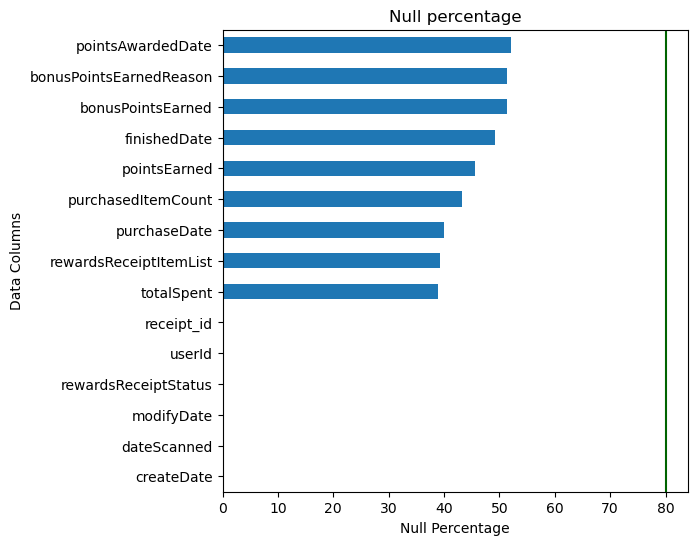

In [59]:
print('Null Percentage for Receipts Table:')
print(get_null_percentage(receipts))
null_percent_plot(receipts, 80, 6, 6)

## Insights:
1. No Missing Values: Critical columns like createDate, dateScanned, modifyDate, rewardsReceiptStatus, and userId have 0% missing values, ensuring complete data for key transaction and user information.
2. Moderate Missing Values: Columns like totalSpent, purchaseDate, and rewardsReceiptItemList have missing values between 30-40%, which could impact analysis involving spending or purchase history if not addressed.
3. High Missing Values: Columns like pointsAwardedDate, bonusPointsEarned, and finishedDate have over 50% missing values, indicating significant gaps, possibly due to incomplete processing or optional fields in receipt submissions.

### Null Percentage for Items Table

Null Percentage for Items Table:
receipt_id                             0.00
partnerItemId                          0.00
finalPrice                             2.51
itemPrice                              2.51
quantityPurchased                      2.51
description                            5.49
discountedItemPrice                   16.89
originalReceiptItemText               17.01
barcode                               55.48
brandCode                             62.54
rewardsProductPartnerId               67.31
rewardsGroup                          75.06
pointsPayerId                         81.75
priceAfterCoupon                      86.23
pointsEarned                          86.64
metabriteCampaignId                   87.57
needsFetchReview                      88.29
competitiveProduct                    90.71
targetPrice                           94.55
preventTargetGapPoints                94.84
pointsNotAwardedReason                95.10
userFlaggedBarcode                    95.14

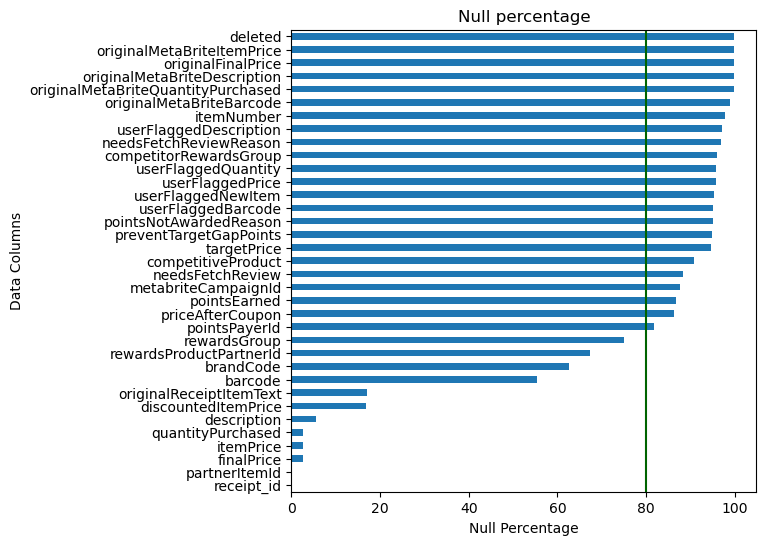

In [63]:
print('Null Percentage for Items Table:')
print(get_null_percentage(items))
null_percent_plot(items, 80, 6, 6)

## Insights:
1. Complete Data: Columns like receipt_id, partnerItemId, and finalPrice have 0% missing values, indicating that the core identifiers and pricing data are well recorded.
2. Moderate Null Values: Columns like itemPrice, quantityPurchased, barcode, and brandCode have missing values ranging from 10-60%. This can affect analyses involving pricing, quantities, and brand associations if not handled properly.
3. High Missing Values: Most columns have over 80% missing values, including fields like deleted, originalMetaBriteBarcode, and userFlaggedNewItem, suggesting these fields are rarely used or optional.


### Null Percentage for Users Table

Null Percentage for Users Table:
active           0.00
createdDate      0.00
role             0.00
user_id          0.00
signUpSource     9.70
state           11.31
lastLogin       12.53
dtype: float64


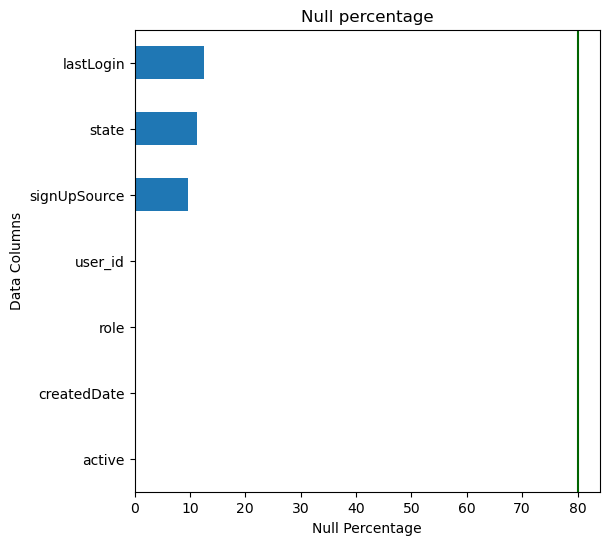

In [66]:
print('Null Percentage for Users Table:')
print(get_null_percentage(users))
null_percent_plot(users, 80, 6, 6)

## Insights:
1. Complete Data: Key fields like user_id, createdDate, active, and role have 0% missing values, indicating robust and complete information for essential user attributes.
2. Moderate Missing Values: Fields like signUpSource, state, and lastLogin have some missing values. These gaps could potentially affect analyses involving user demographics and activity patterns.

### Null Percentage for Brands Table

Null Percentage for Brands Table:
_id              0.00
barcode          0.00
cpg              0.00
name             0.00
category        13.28
brandCode       20.05
topBrand        52.44
categoryCode    55.70
dtype: float64


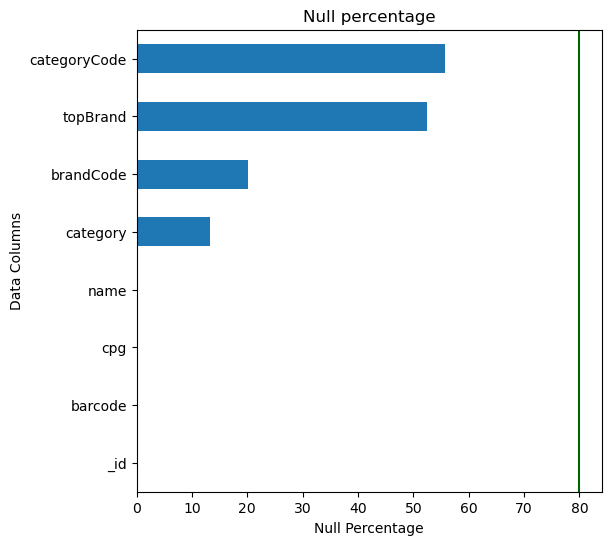

In [69]:
print('Null Percentage for Brands Table:')
print(get_null_percentage(brands))
null_percent_plot(brands, 80, 6, 6)

## Insights:
1. Complete Data: Core columns like _id, barcode, cpg, and name have 0% missing values, indicating that key brand identifiers and names are fully populated.
2. Moderate Missing Values: Columns like category and brandCode have moderate null values, which may impact analysis involving brand categorization and codes.
3. High Missing Values: topBrand and categoryCode has missing values, suggesting incomplete or optional categorization for many brands.

## Step 7 - Checking Numerical Distribution 
We will check if there are any potential outliers for numerical columns.

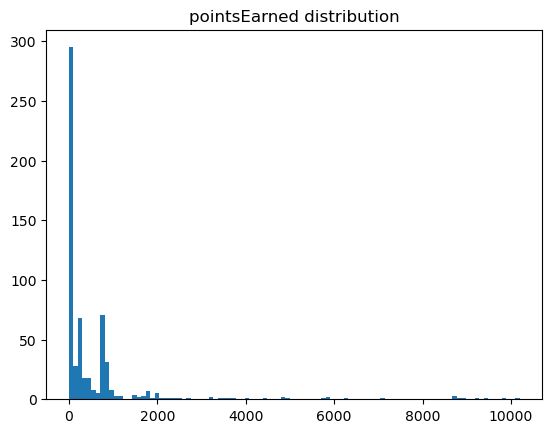

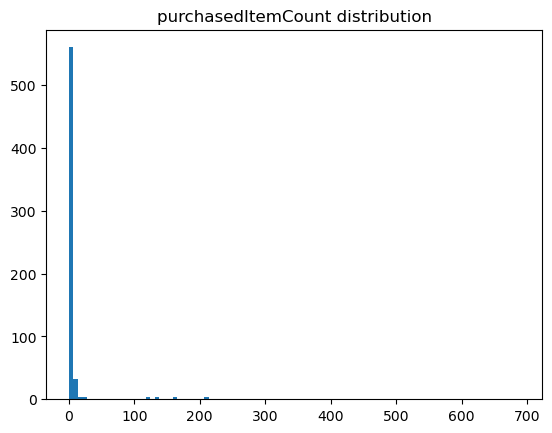

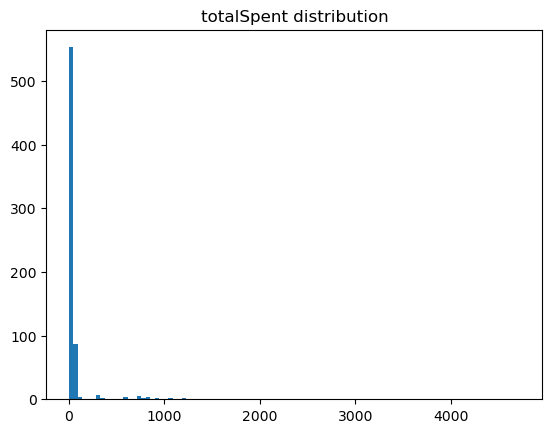

In [72]:
# Create a function to plot the histogram of a column
def plot_col_distribution(df, col, bins):
    df[col].hist(bins=bins)
    plt.title(f"{col} distribution")
    plt.gca().grid(False)
    plt.show()

# Create a function to show histograms for columns whose maximum value is greater than a user-defined sigma value
def plot_potential_outliers(df, num_sigma, bins):
    stats = df.describe().transpose()
    cols = stats[stats['max'] > stats['mean'] + stats['std'] * num_sigma].index.tolist()
    for col in cols:
        plot_col_distribution(df, col, bins=bins)

# Use the function to see the columns whose maximum is greater than 3 standard deviations
plot_potential_outliers(receipts, 3, 100)

## Insights
#### All distributions are right-skewed, indicating that most values are low with a few high outliers.
1. Points Earned: Most users earn few points, but there are some very high point earnings (potential outliers).
2. Purchased Item Count: Most receipts have a low item count, but a few show extremely high counts (possibly bulk purchases or data errors).
3. Total Spent: Majority of receipts show small spending (<200), but some indicate very high spending (> $4000), which needs verification.
Business validation is needed to confirm if the high values are expected or are anomalies.

## Step 8 - Checking for Duplicate Records

In [93]:
# Function to check for duplicates after dropping unhashable columns
def check_for_duplicates(df, table_name):
    # Drop columns that might contain lists or dictionaries
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (list, dict))).any():
            df = df.drop(col, axis=1)
    
    # Check for duplicate records
    duplicate_df = df[df.duplicated()]
    print(f"Duplicate Rows in {table_name} Table:")
    print(duplicate_df)
    if duplicate_df.empty:
        print(f"No duplicate records found in {table_name} Table.\n")

In [95]:
check_for_duplicates(receipts, "Receipts")

Duplicate Rows in Receipts Table:
Empty DataFrame
Columns: [bonusPointsEarned, bonusPointsEarnedReason, createDate, dateScanned, finishedDate, modifyDate, pointsAwardedDate, pointsEarned, purchaseDate, purchasedItemCount, rewardsReceiptStatus, totalSpent, userId, receipt_id]
Index: []
No duplicate records found in Receipts Table.



In [97]:
check_for_duplicates(users, "Users")


Duplicate Rows in Users Table:
     active         createdDate           lastLogin         role signUpSource  \
1      True 2021-01-03 07:24:04 2021-01-03 07:25:37     consumer        Email   
2      True 2021-01-03 07:24:04 2021-01-03 07:25:37     consumer        Email   
4      True 2021-01-03 07:24:04 2021-01-03 07:25:37     consumer        Email   
5      True 2021-01-03 07:24:04 2021-01-03 07:25:37     consumer        Email   
8      True 2021-01-03 07:24:04 2021-01-03 07:25:37     consumer        Email   
..      ...                 ...                 ...          ...          ...   
490    True 2014-12-19 06:21:22 2021-03-05 08:52:23  fetch-staff          NaN   
491    True 2014-12-19 06:21:22 2021-03-05 08:52:23  fetch-staff          NaN   
492    True 2014-12-19 06:21:22 2021-03-05 08:52:23  fetch-staff          NaN   
493    True 2014-12-19 06:21:22 2021-03-05 08:52:23  fetch-staff          NaN   
494    True 2014-12-19 06:21:22 2021-03-05 08:52:23  fetch-staff          NaN 

In [99]:
check_for_duplicates(brands, "Brands")


Duplicate Rows in Brands Table:
Empty DataFrame
Columns: [barcode, category, categoryCode, name, topBrand, brandCode]
Index: []
No duplicate records found in Brands Table.



In [103]:
check_for_duplicates(items, "Items")


Duplicate Rows in Items Table:
Empty DataFrame
Columns: [receipt_id, barcode, description, finalPrice, itemPrice, needsFetchReview, partnerItemId, preventTargetGapPoints, quantityPurchased, userFlaggedBarcode, userFlaggedNewItem, userFlaggedPrice, userFlaggedQuantity, needsFetchReviewReason, pointsNotAwardedReason, pointsPayerId, rewardsGroup, rewardsProductPartnerId, userFlaggedDescription, originalMetaBriteBarcode, originalMetaBriteDescription, brandCode, competitorRewardsGroup, discountedItemPrice, originalReceiptItemText, itemNumber, originalMetaBriteQuantityPurchased, pointsEarned, targetPrice, competitiveProduct, originalFinalPrice, originalMetaBriteItemPrice, deleted, priceAfterCoupon, metabriteCampaignId]
Index: []

[0 rows x 35 columns]
No duplicate records found in Items Table.



## Insights:
1. Receipts Table: No duplicate records were found, indicating that the receipt data is clean and unique.
2. Users Table:Found 283 duplicate rows based on columns such as user_id, createdDate, lastLogin, role, etc.
3. Brands Table: No duplicate records were found, meaning that each brand entry is unique as expected.
4. Items Table: No duplicate records were found, ensuring that each item record is distinct.

In [110]:
# Export each DataFrame to CSV
receipts.to_csv('/Users/spartan/Downloads/receipts.csv', index=False)
items.to_csv('/Users/spartan/Downloads/items.csv', index=False)
users.to_csv('/Users/spartan/Downloads/users.csv', index=False)
brands.to_csv('/Users/spartan/Downloads/brands.csv', index=False)